# Contribution to the 2020 BraTS Challenge: Automated Segmentation using 3D Attention UNet 
Diedre Santos do Carmo

## Abstract
This is an abstract.

## Introduction
Assessment of brain tumors is important in the diagnostic of Cancer [Cite Medicine Paper]. Automatic segmentation can aid in this assessment, allowing for description of relevant tumor features such as its volume. However, tumors are very heterogeneous in shape, having different associated grades and classifications. Due to this variance, automatic segmentation of brain tumors is still a challenge [BraTS Journal].

A source of public Glioma brain tumors is the BraTS challenge [BraTS Journal]. This challenge expects high quality automatic segmentations of glioma regions, annotated over the provided four modalities of magnetic ressonance imaging (MRI). The conception of the challenge came from the high inter-rater disagreement between expert raters in 2012 of up to 0.74 DICE [GDL]. Currently, most top-ranking methods in the challenge use Deep Learning [Deep Learning Nature] based methods. 

![intro_fig](figures/tumor_brats.png)<br>
Figure 1: A sample manual annotation of a glioma. (a) edema (yellow), (b) non-enhancing solid core (red), (c) necrotic/cystic core (green), enhancing core(blue). (d) Combined segmentations. Reproduced from {menze2014multimodal}.

Adaptation of the famous UNet [Ronnenberg] architecture is a common approach in recent years, with many succesful methods [(Kamnitsas, 2017), (Isensee, 2017), (Myronenko, 2018), (Myronenko, 2019), (Jyang, 2019)]. 

Kamnitsas Et al. [Kamnitsas, 2017] achieved top perfomance using an ensemble of four medical image segmentation CNN architectures, including 2 U-Net based ones, winning BRATS in 2017. The author proposes that its ensemble strategy aims to reduce the impact of different hyperparameters and bias employed to each architecture, by averaging their results.

Isensee Et al.'s [Isensee, 2017] method adapted the UNet for 3D convolutions, with more skip connections, less channels, intensive augmentation, and a multi-class adaptation of DICE Loss that would be later called Generalized Dice Loss [GDL]. Interestingly, Isensee Et al. is one of the leading methods from the 2017 challenge using mostly a single U-Net architecture, showing that a well trained U-Net can be superior to complex ensemble approaches.

The winner of the 2018 challenge also used an U-Net like architecture [Myronenko, 2018]. The main novelty of this work consisted of using a second branch in the decoder part of the architecture, reconstructing the original image as a means of regularization of the encoder. Another difference to basic U-Net is the use of a larger encoder, while most works keep the symmetry between encoder and decoder. 

(Myronenko, 2019)...

(Jyang, 2019)...

UNet like architectures have been achieving top performance in BraTS year after year. This paper proposes to further explore the potential of the UNet encoder-decoder architecture, with the use of attention modules and other modifications recently featured in the literature...

## Executable Paper
This is an executable paper. The code cells can be run to reproduce important steps of this research. Code Cell 0 will setup the enviroment. 

MLflow is used to manage experiment runs, logging to the cell output what command was executed. Details from each run can be visualized by runnning "mlflow ui" on the directory of this notebook and accessing http://localhost:5000 on your browser. 

### Code Cell 0: Import needed libraries.

In [29]:
import mlflow
import os

from src.notebook_utils import view_image

# Intermediate place to save mlflow logs
os.makedirs("logs", exist_ok=True)

## Data
BraTS 2020 scans are available as NIfTI files of various modalities: T1, post-contrast T1, T2, and FLAIR volumes, acquired with different clinical protocols and various scanners from multiple institutions[BraTS].

Subjects have manual segmentation, performed by one to four raters, following the same protocol, with the resulting segmentation being approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor, the peritumoral edema, and the necrotic and non-enhancing tumor core, as described in the latest BraTS summarizing paper [BratS]. The provided data are distributed after pre-processing: co-registration to the same anatomical template, interpolation to the same resolution and skull-stripping.

Additional pre-processing applied in this paper follows Isensee Et al.'s [Isensee] pre-processing. The images are subtracted by the mean and divided by the standard deviation of the brain region, and clipped inside the interval -5 to 5. Finally, they are min-max normalized to the interval 0 to 1.

The training data for 2020's challenge will be downloaded by Code Cell 1 and the pre processing can be reproduced by Code Cell 2. 
This paper will use cross-validation on this training data, since the challenge test sets are not available yet.  


### Code Cell 1: Download the original BraTS 2020 data from figshare and unpack.

In [31]:
if not os.path.isfile(os.path.join("data", "data.zip")):
    print("Original data not found, downloading it...")
    !wget https://ndownloader.figshare.com/files/22813406?private_link=466e909eea5a3e8ec1e3 -O data/data.zip
else:
    print("Original data already downloaded.")

if os.path.isdir("data/MICCAI_BraTS2020_TrainingData"):
    print("Original data already unpacked.")
else:
    print("Decompressing data...")
    !unzip -q data/data.zip -d data
    print("Done.")

Original data already downloaded.
Original data already unpacked.


### Code Cell 2: Preprocess the data.

In [32]:
parameters = {"data_path": "data/MICCAI_BraTS2020_TrainingData"}
print("Performing pre-processing, this might take some minutes.")
run = mlflow.projects.run('.', entry_point="pre_process", use_conda=False, 
                          parameters=parameters,
                          experiment_name="pre_processing")
print("Pre-processing done. Logs saved as mlflow artifact.")

2020/05/27 21:50:09 INFO mlflow.projects: === Created directory /tmp/tmp5cy8quk6 for downloading remote URIs passed to arguments of type 'path' ===
2020/05/27 21:50:09 INFO mlflow.projects: === Running command 'python3 src/brats_preprocess.py --data_path /home/diedre/git/BTRSeg/data/MICCAI_BraTS2020_TrainingData' in run with ID 'fa29ddcf280b48d0856bb0a1e80b5ccc' === 
Performing pre-processing, this might take some minutes.
2020/05/27 21:57:11 INFO mlflow.projects: === Run (ID 'fa29ddcf280b48d0856bb0a1e80b5ccc') succeeded ===
Pre-processing done. Logs saved as mlflow artifact.


### Code Cell 3: Generates and visualizes a display of the pre-processed data.

2020/05/27 22:25:43 INFO mlflow.projects: === Created directory /tmp/tmpgyq4z2pg for downloading remote URIs passed to arguments of type 'path' ===
2020/05/27 22:25:43 INFO mlflow.projects: === Running command 'python3 src/visualize_npz.py --input /home/diedre/git/BTRSeg/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_preprocessed.npz --no_display' in run with ID 'bf7dbd3cb9d5489e86ef1d3254e13337' === 
Generating data visualization...
2020/05/27 22:25:46 INFO mlflow.projects: === Run (ID 'bf7dbd3cb9d5489e86ef1d3254e13337') succeeded ===
Visualization logged as an artifact and saved in figures/display.png


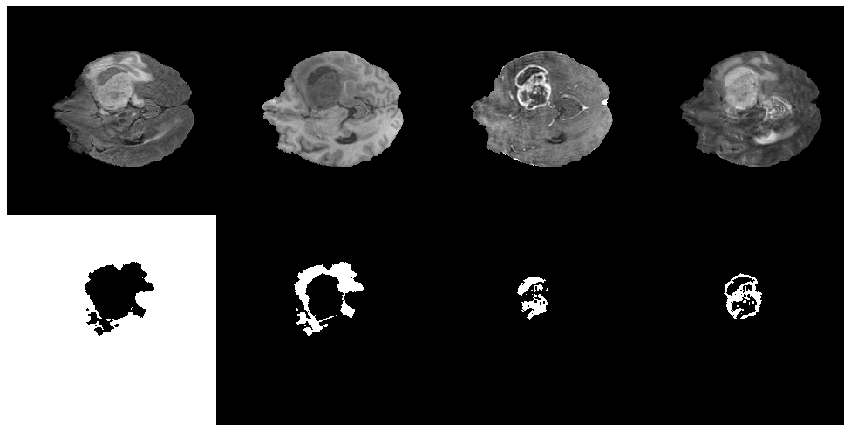

In [33]:
parameters = {"input": "data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_preprocessed.npz"}
print("Generating data visualization...")
run = mlflow.projects.run('.', entry_point="visualize", use_conda=False, 
                          parameters=parameters,
                          experiment_name="pre_processing")  
print("Visualization logged as an artifact and saved in figures/display.png")

# This image is generated by the above run. Change the input to generate and visualize for another .npz file.
view_image("figures/display.png")                           

Figure 1: The four modalities are showcased, in order: FLAIR, T1, T1 with Contrast and T2. Also displayed in the bottom row are the four segmentation targets: background, edema, non-enhancing tumor and enhancing tumor.

## Methodology
This method, named BTRSeg, leverages modified, fully 3D, attention based, UNet like encoder-decoder CNNs. 

## Experiments and Results
Experiments are being performed.

## Discussion
Results show that...

## Conclusion
We conclude that...

## References
[1] AAAA<br>
[2] BBBB<br>

Problems:<br>
-How to use references in Jupyter?<br>
-Image captions? Tables?<br>